In [ ]:
# get data
! cp -r ~/data-store/data/iplant/home/shared/earthlab/forest_carbon_codefest/Disturbance/LF_Public_Events_1999_2022 ./LF_Events

In [2]:
! wget --no-check-certificate https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/us/us_eco_l3.zip

--2024-03-12 23:18:52--  https://gaftp.epa.gov/EPADataCommons/ORD/Ecoregions/us/us_eco_l3.zip
Resolving gaftp.epa.gov (gaftp.epa.gov)... 134.67.100.99, 2620:117:506f:c7::f063
Connecting to gaftp.epa.gov (gaftp.epa.gov)|134.67.100.99|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 28424315 (27M) [application/zip]
Saving to: ‘us_eco_l3.zip’

us_eco_l3.zip       100%[===================>]  27.11M  2.92MB/s    in 8.4s    

2024-03-12 23:19:01 (3.21 MB/s) - ‘us_eco_l3.zip’ saved [28424315/28424315]



In [26]:
import geopandas as gpd
from collections import Counter
import shapely
import json
import matplotlib.pyplot as plt

In [4]:
us_eco = gpd.read_file("us_eco_l3.zip").to_crs("EPSG:4326")
s_rock_aoi = us_eco[us_eco.US_L3NAME == "Southern Rockies"].geometry.unary_union

In [5]:
event_df = gpd.read_file(
    "./LF_Events/LF_Public_Events_1999_2022.gdb",
    layer="CONUS_230_PublicModelReadyEvents"
).to_crs("EPSG:4326")

In [6]:
s_rock_events = event_df[event_df.intersects(s_rock_aoi)]

In [9]:
print(s_rock_events.shape)
print(Counter(s_rock_events.Event_Type))

(69506, 16)
Counter({'Insects': 28857, 'Insects/Disease': 6430, 'Prescribed Fire': 6364, 'Other Mechanical': 6307, 'Herbicide': 5940, 'Thinning': 4471, 'Wildfire': 2637, 'Clearcut': 1704, 'Harvest': 1524, 'Planting': 1155, 'Chemical': 1098, 'Disease': 872, 'Mastication': 773, 'Wildland Fire': 430, 'Weather': 402, 'Biological': 262, 'Seeding': 145, 'Development': 75, 'Wildland Fire Use': 42, 'Reforestation': 12, 'Insecticide': 6})


In [19]:
with open("southern_rockies_eco.geojson", "w") as fh:
    fh.write(shapely.to_geojson(s_rock_aoi))

In [ ]:
s_r_e_utm = s_rock_events.to_crs("EPSG:32613")

In [50]:
# combine all the cats into more general cats
def simple_cats(input_cat: str) -> str:
    """Map catagories to something simple"""
    match input_cat:
        case "Insects" | "Insects/Disease":
            return "insect"
        case 'Wildfire':
            return "fire"
        case 'Prescribed Fire' | 'Wildland Fire' | 'Wildland Fire Use' | 'Other Mechanical' | 'Herbicide' | 'Thinning' | 'Clearcut' | 'Harvest' | 'Planting' | 'Chemical' | 'Disease' | 'Mastication' | 'Weather' | 'Biological' | 'Seeding' | 'Development' | 'Reforestation' | 'Insecticide':
            return "other"

In [51]:
s_r_e_utm["simple_cat"] = s_r_e_utm.Event_Type.apply(simple_cats)

In [52]:
Counter(s_r_e_utm.simple_cat)

Counter({'insect': 35287, 'other': 31582, 'fire': 2637})

array([[<Axes: title={'center': 'fire'}>,
        <Axes: title={'center': 'insect'}>],
       [<Axes: title={'center': 'other'}>, <Axes: >]], dtype=object)

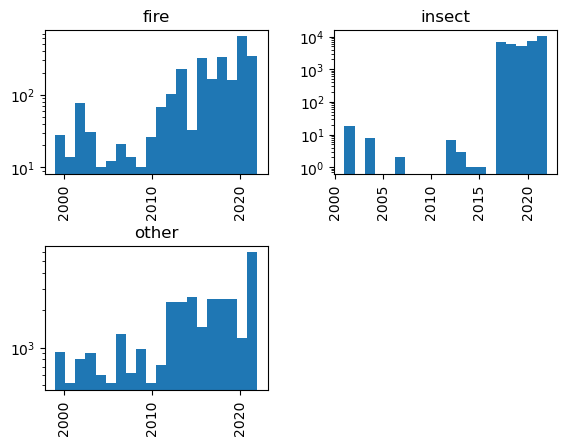

In [61]:
# type = "insect"
# type = "fire"
# type = "other"
# plt.hist(s_r_e_utm[s_r_e_utm.simple_cat == type].Year, bins=20, log=True, weights=s_r_e_utm[s_r_e_utm.simple_cat == type].area)
s_r_e_utm.hist(by="simple_cat", column=["Year", "simple_cat"], bins=20, log=True)

In [62]:
s_r_e_utm.to_file("southern_rockies_simplified_events.gpkg")